# Burgers Equation UPINN

In [1]:
import torch
import sys
from scipy.stats import qmc # For hypercube sampling
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from UPINN import UPINN
from Architectures import FNN
from Utils import RAD_sampler, SINDy_sklearn, SoftAdapt

Consider Burgers equation:

\begin{align}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{align}

where $u(x,t)$ is the velocity field, $\nu$ is the viscosity coefficient, $x \in [-1,1]$ and $t \in [0,1]$. The initial condition is $u(x,0) = -\sin(\pi x)$ and the boundary conditions are $u(-1,t) = u(1,t) = 0$.

### Setup Boundary Value Problem

In [2]:
# Initial condition
N_ic = 100
u0 = lambda x: -torch.sin(torch.pi * x)
x0 = torch.linspace(-1, 1, N_ic)
t0 = torch.zeros_like(x0)
X0 = torch.stack((t0, x0), dim=-1)
U0 = u0(x0).reshape(-1, 1)

# Boundary condition
N_bc = 100
uL = lambda t: torch.zeros_like(t)
uR = lambda t: torch.zeros_like(t)
tL = torch.linspace(0, 1, N_bc)
tR = torch.linspace(0, 1, N_bc)
xL = -torch.ones_like(tL)
xR = torch.ones_like(tR)
XL = torch.stack((tL, xL), dim=-1)
XR = torch.stack((tR, xR), dim=-1)

# All boundary conditions
Xbc = torch.cat((X0, XL, XR), dim=0)
Ubc = torch.cat((U0, uL(tL).reshape(-1, 1), uR(tR).reshape(-1, 1)), dim=0)

In [3]:
# Collocation points
N_coll = 10000
sobol = torch.quasirandom.SobolEngine(dimension=2)
hypercube = qmc.LatinHypercube(d=2)
# Xc = torch.tensor(hypercube.random(n=N_coll), dtype=torch.float32)
Xc = sobol.draw(n=N_coll, dtype=torch.float32)
Xc[:, 1] = Xc[:, 1]*2 - 1
Xc[:, 0] = Xc[:, 0]

In [4]:
# Load data
data = np.load('data/Burgers.npz')
tsol, xsol, usol = data['t'], data['x'], data['usol']

In [5]:
times = [0.5]
times_idx = (np.array(times)*100).astype(int)

Xd = torch.tensor(np.vstack([np.hstack([t*np.ones_like(xsol.flatten()) for t in times]), np.tile(xsol.flatten(), len(times))]).T, dtype=torch.float32)
Ud = torch.concat([torch.tensor(usol[:, idx], dtype=torch.float32).reshape(-1, 1) for idx in times_idx], dim=0)

# Add noise
noise_level = 1.0
Ud = Ud + noise_level * torch.mean(abs(Ud)) * torch.randn(*Ud.shape)

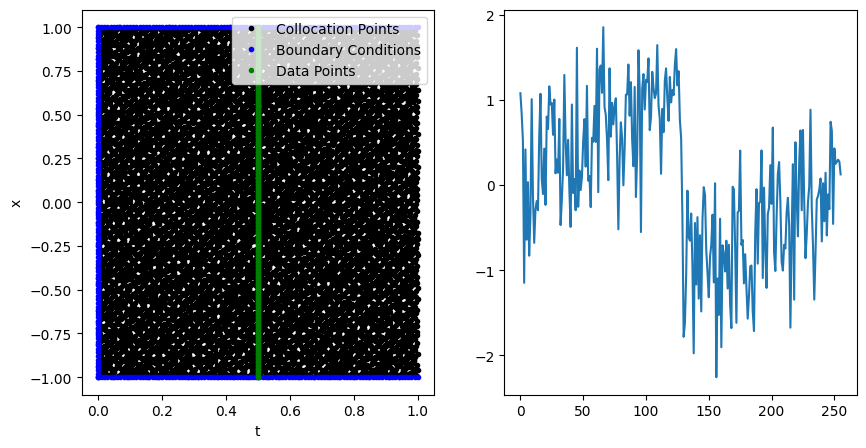

In [6]:
# Plot the initial condition, boundary conditions, and collocation points
ax, fig = plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(Xc[:, 0], Xc[:, 1], 'k.', label='Collocation Points')
plt.plot(Xbc[:, 0], Xbc[:, 1], 'b.', label='Boundary Conditions')
plt.plot(Xd[:, 0], Xd[:, 1], 'g.', label='Data Points')
plt.xlabel('t'); plt.ylabel('x'); plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Ud.reshape(-1, len(times)))
plt.show()

### Setup Boundary Value Problem

In [7]:
class SparseBurger(torch.nn.Module):
    def __init__(self, nu):
        super(SparseBurger, self).__init__()
        self.nu = nu
    
    def forward(self, X, u):

        d2udxt = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
        u_t = d2udxt[:,0:1]
        u_x = d2udxt[:,1:2]

        u_xx = torch.autograd.grad(d2udxt, X, torch.ones_like(d2udxt), create_graph=True)[0][:,1:2]

        return u_t - self.nu*u_xx

class NoBurger(torch.nn.Module):
    def __init__(self, nu):
        super(NoBurger, self).__init__()
        self.nu = nu

        self.alpha = torch.nn.Parameter(torch.tensor(0.099))
        self.beta = torch.nn.Parameter(torch.tensor(0.002))
        self.gamma = torch.nn.Parameter(torch.tensor(0.534))
        self.delta = torch.nn.Parameter(torch.tensor(0.070))

    def forward(self, X, u):


        # -0.099 u + 0.002 u_11 + -0.534 uu_1 + 0.070 uuu_1

        d2udxt = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
        u_t = d2udxt[:,0:1]
        u_x = d2udxt[:,1:2]

        u_xx = torch.autograd.grad(d2udxt, X, torch.ones_like(d2udxt), create_graph=True)[0][:,1:2]

        return u_t #- self.alpha*u + self.beta*u_xx - self.gamma*u*u_x + self.delta*u*u*u_x

### Initialize and train UPINN

In [ ]:
def F_in(X, U):
    dudxt = torch.autograd.grad(U, X, torch.ones_like(U), create_graph=True)[0]
    u_t = dudxt[:,0:1]
    u_x = dudxt[:,1:2]
    return torch.cat((U, u_t, u_x), dim=-1)

class UPINN(UPINN):

    def refine_collocation_points(self):
        N = 50*N_coll
        D = N_coll
        k = 0.5
        c = 0.1

        Xc = sobol.draw(n=N, dtype=torch.float32)
        Xc[:, 1] = Xc[:, 1]*2 - 1
        Xc.requires_grad_(True)

        # Compute the residual
        u = self.u(Xc)
        F_input = F_in(Xc, u)
        # G_input = Xc
        # G_input = u
        # G_input = torch.cat((u, Xc), dim=-1)
        residual = abs(self.N(Xc, u) + self.F(F_input))
        
        self.collocation_points = RAD_sampler(Xc, residual, D, k, c)
    
    def score(self, X, U):
        return torch.nn.MSELoss()(self.predict(Zsol), U)

    def F_input(self, X, U):
        dudxt = torch.autograd.grad(U, X, torch.ones_like(U), create_graph=True)[0]
        u_t = dudxt[:,0:1]
        u_x = dudxt[:,1:2]
        return torch.cat((U, u_t, u_x), dim=-1)

    def get_loss(self):
        bc_loss = self.bc_loss()
        data_loss = self.data_loss()
        pde_loss = self.pde_loss()
        loss = bc_loss + data_loss + pde_loss
        return loss, bc_loss, data_loss, pde_loss

    def plot(self):
        device = self.device
        self.to('cpu')

        # Get network prediction
        x_plot = np.linspace(-1, 1, 1000)
        t_plot = np.linspace(0, 1, 1000)
        T, X = np.meshgrid(t_plot, x_plot)
        T_tensor = torch.tensor(T.flatten(), dtype=torch.float32).reshape(-1, 1)
        X_tensor = torch.tensor(X.flatten(), dtype=torch.float32).reshape(-1, 1)
        z_plot = torch.cat((T_tensor, X_tensor), dim=-1)
        z_plot.requires_grad_(True)
        u_pred = self.u(z_plot)

        
        dudz_pred = torch.autograd.grad(u_pred, z_plot, torch.ones_like(u_pred), create_graph=True)[0]
        u_t_pred = dudz_pred[:, 0:1]
        u_x_pred = dudz_pred[:, 1:2]

        res_pred = self.F(torch.cat((u_pred, u_t_pred, u_x_pred), dim=-1))

        # Get the known solution
        dudx = np.gradient(usol, xsol.flatten(), axis=0)

        with torch.no_grad():
            
            u_pred = u_pred.reshape(1000, 1000).detach().numpy()
            u_t_pred = u_t_pred.reshape(1000, 1000).detach().numpy()
            u_x_pred = u_x_pred.reshape(1000, 1000).detach().numpy()
            res_pred = res_pred.reshape(1000, 1000).detach().numpy()

            plt.figure(figsize=(10, 3))

            # Slices of the predicted solution and the known solution
            plt.subplot(1, 2, 1)
            colors = ['b', 'g', 'r', 'c', 'm']  # Define a list of colors for the lines

            plt.plot(x_plot, u_pred[:, 0], label='t=0', color=colors[0])
            plt.plot(x_plot, u_pred[:, 250], label='t=0.25', color=colors[1])
            plt.plot(x_plot, u_pred[:, 500], label='t=0.5', color=colors[2])
            plt.plot(x_plot, u_pred[:, 750], label='t=0.75', color=colors[3])
            plt.plot(x_plot, u_pred[:, 999], label='t=1', color=colors[4])

            plt.plot(xsol, usol[:, 0], '--', color=colors[0])
            plt.plot(xsol, usol[:, 25], '--', color=colors[1])
            plt.plot(xsol, usol[:, 50], '--', color=colors[2])
            plt.plot(xsol, usol[:, 75], '--', color=colors[3])
            plt.plot(xsol, usol[:, 99], '--', color=colors[4])

            plt.xlabel('x'); plt.ylabel('u')
            plt.legend()
            plt.title('Predicted Solution vs. Known Solution')


            # Slices of the predicted residuals and known residuals
            plt.subplot(1, 2, 2)

            plt.plot(x_plot[450:550], res_pred[450:550, 0], label='t=0', color=colors[0])
            plt.plot(x_plot[450:550], res_pred[450:550, 250], label='t=0.25', color=colors[1])
            plt.plot(x_plot[450:550], res_pred[450:550, 500], label='t=0.5', color=colors[2])
            plt.plot(x_plot[450:550], res_pred[450:550, 750], label='t=0.75', color=colors[3])
            plt.plot(x_plot[450:550], res_pred[450:550, 999], label='t=1', color=colors[4])

            plt.plot(xsol[115:140], -dudx[115:140, 75]*usol[115:140, 75], '--', color=colors[0])
            plt.plot(xsol[115:140], -dudx[115:140, 75]*usol[115:140, 75], '--', color=colors[1])
            plt.plot(xsol[115:140], -dudx[115:140, 75]*usol[115:140, 75], '--', color=colors[2])
            plt.plot(xsol[115:140], -dudx[115:140, 75]*usol[115:140, 75], '--', color=colors[3])
            plt.plot(xsol[115:140], -dudx[115:140, 75]*usol[115:140, 75], '--', color=colors[4])

            plt.xlabel('x'); plt.ylabel('Residual')
            plt.legend()
            plt.title('Predicted Residual vs. Known Residual')

            plt.tight_layout()
            plt.show()


            # Find the global vmin and vmax (same for all subplots)
            known_res = -dudx*usol
            exp_res = -u_x_pred*u_pred
            res_err = abs(res_pred - (exp_res))
            res_pred = res_pred

            plt.figure(figsize=(10, 8))

            vmin = min(usol.min(), u_pred.min())
            vmax = max(usol.max(), u_pred.max())
            v = max(abs(vmin), abs(vmax))

            # Known solution
            plt.subplot(3, 2, 1)
            plt.imshow(usol, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=-v, vmax=v)
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Known Solution')
            plt.colorbar()

            # Predicted solution
            plt.subplot(3, 2, 2)
            plt.imshow(u_pred, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=-v, vmax=v)
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Predicted Solution')
            plt.colorbar()

            vmin = min(known_res.min(), exp_res.min(), res_err.min(), res_pred.min())
            vmax = max(known_res.max(), exp_res.max(), res_err.max(), res_pred.max())
            v = max(abs(vmin), abs(vmax))

            # Known residual
            plt.subplot(3, 2, 3)
            plt.imshow(known_res, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=-v, vmax=v)
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Known Residual')
            plt.colorbar()

            # Predicted residual
            plt.subplot(3, 2, 4)
            plt.imshow(res_pred, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=-v, vmax=v)
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Predicted Residual')
            plt.colorbar()

            # Expected residual
            plt.subplot(3, 2, 5)
            plt.imshow(exp_res, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=-v, vmax=v)
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Expected Residual')
            plt.colorbar()

            # Residual error
            plt.subplot(3, 2, 6)
            plt.imshow(res_err, extent=(0, 1, -1, 1), origin='lower', aspect='auto')
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Residual Error')
            plt.colorbar()

            plt.tight_layout()
            plt.show()
        
        self.to(device)

In [10]:
hidden = [20] * 8

u = NN(
    dims=[2, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

F = FNN(
    dims=[3, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

# u = lambda x: (x[:, 0:1] + 1) * (1 - x[:, 0:1]) * u(x)

nu = 0.01/torch.pi
N = SparseBurger(nu)

from kan import KAN

F_kan = KAN([3, 2, 2, 1], grid=5, k=3)

# Instantiate the UPINN
upinn = UPINN(u, N, F, boundary_points=(Xbc, Ubc), data_points=(Xd, Ud), collocation_points=Xc)

checkpoint directory created: ./model
saving model version 0.0
[Info]: Initializing UPINN model


In [11]:
Tsol, Xsol = np.meshgrid(tsol, xsol)
Tsol_tensor = torch.tensor(Tsol.flatten(), dtype=torch.float32).reshape(-1, 1)
Xsol_tensor = torch.tensor(Xsol.flatten(), dtype=torch.float32).reshape(-1, 1)
Zsol = torch.cat((Tsol_tensor, Xsol_tensor), dim=-1)
Usol = torch.tensor(usol.flatten(), dtype=torch.float32).reshape(-1, 1)

### Alternating optimizers

In [12]:
adamw = torch.optim.AdamW(upinn.parameters(), lr=1e-3)
lbfgs = torch.optim.LBFGS(upinn.parameters(), history_size=20, max_iter=10)
for _ in range(1):
    upinn.optimizer = adamw
    upinn.train_loop(1000)
    upinn.optimizer = lbfgs
    upinn.train_loop(100)
    upinn.refine_collocation_points()

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:28<00:00, 34.70 epoch/s, L=4.35e-02, L_bc=5.32e-15, L_data=4.34e-01, L_pde=1.07e-04]


[Info]: Training 100 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 100/100 [00:41<00:00,  2.40 epoch/s, L=3.20e-02, L_bc=5.32e-15, L_data=3.15e-01, L_pde=5.50e-04]


In [13]:
x_plot = np.linspace(-1, 1, 1000)
t_plot = np.linspace(0, 1, 1000)
T, X = np.meshgrid(t_plot, x_plot)
T_tensor = torch.tensor(T.flatten(), dtype=torch.float32).reshape(-1, 1)
X_tensor = torch.tensor(X.flatten(), dtype=torch.float32).reshape(-1, 1)
z_plot = torch.cat((T_tensor, X_tensor), dim=-1)
z_plot.requires_grad_(True)

tensor([[ 0.0000, -1.0000],
        [ 0.0010, -1.0000],
        [ 0.0020, -1.0000],
        ...,
        [ 0.9980,  1.0000],
        [ 0.9990,  1.0000],
        [ 1.0000,  1.0000]], requires_grad=True)

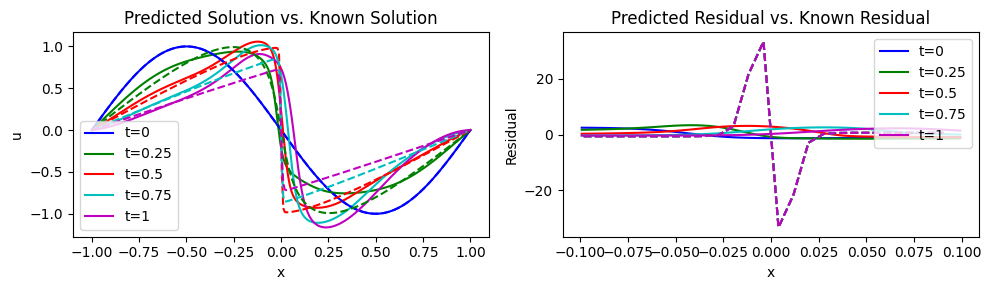

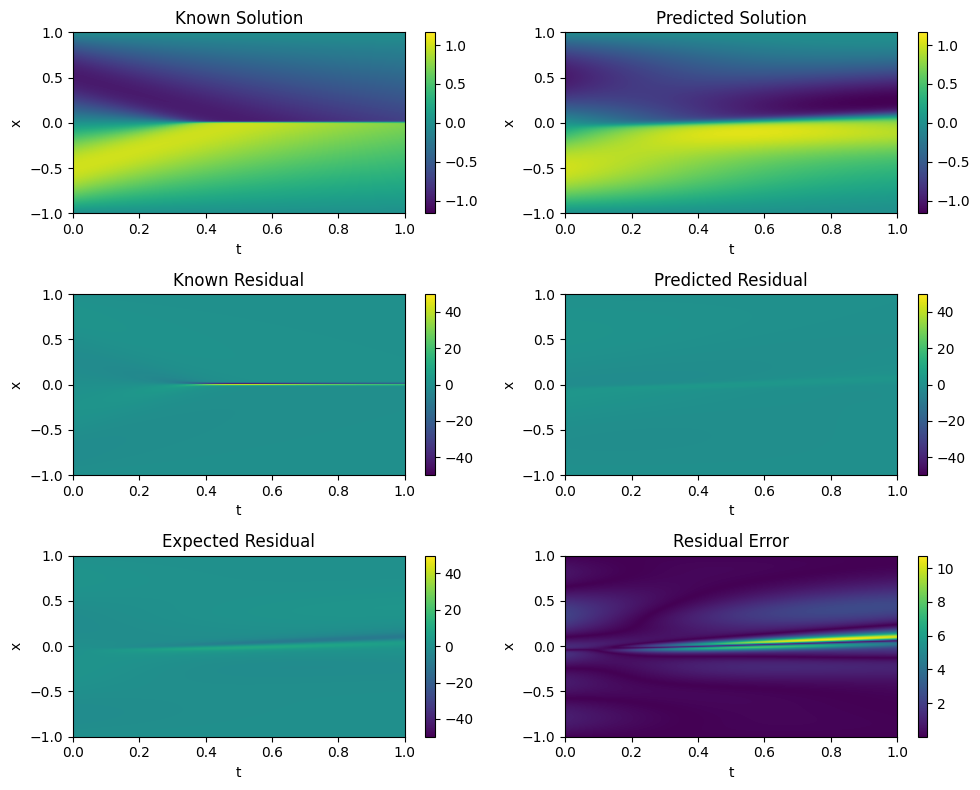

In [14]:
upinn.plot()

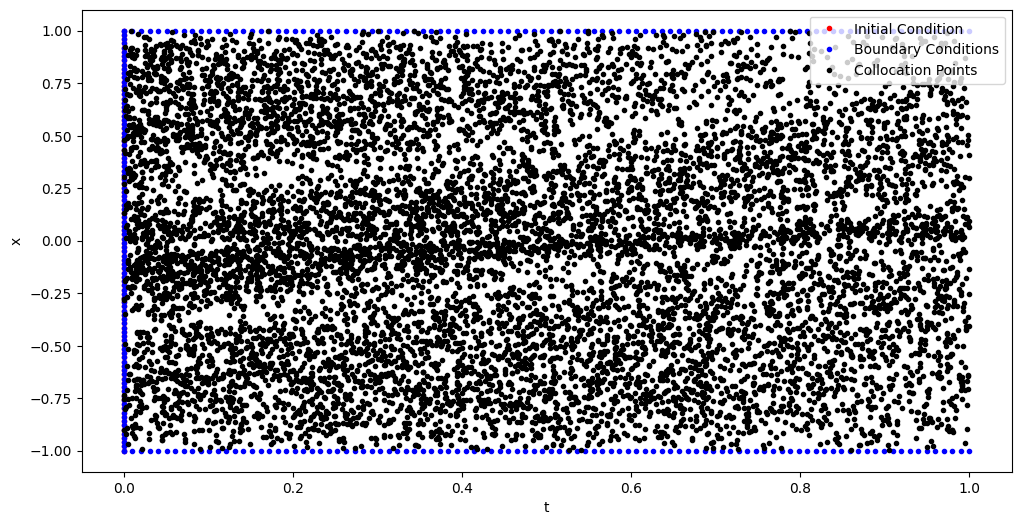

In [15]:
upinn.to('cpu')
# upinn.refine_collocation_points()
# Plot the initial condition, boundary conditions, and collocation points
plt.figure(figsize=(12, 6))
plt.plot(X0[:, 0], X0[:, 1], 'r.', label='Initial Condition')
plt.plot(Xbc[:, 0], Xbc[:, 1], 'b.', label='Boundary Conditions')
plt.plot(upinn.collocation_points[:, 0].detach(), upinn.collocation_points[:, 1].detach(), 'k.', label='Collocation Points')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()

### Plot Results

\begin{align}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{align}

### PDE find (SINDy)

In [16]:
import pysindy as ps

In [19]:
t = np.linspace(0, 1, 101)
x = np.linspace(-1, 1, 256)
T, X = np.meshgrid(t, x)

T_tensor = torch.tensor(T.flatten(), dtype=torch.float32).reshape(-1, 1)
X_tensor = torch.tensor(X.flatten(), dtype=torch.float32).reshape(-1, 1)
Z_tensor = torch.cat((T_tensor, X_tensor), dim=-1)
Z_tensor.requires_grad_(True)
U_tensor = upinn.u(Z_tensor)
dUdZ = torch.autograd.grad(U_tensor, Z_tensor, torch.ones_like(U_tensor), create_graph=True)[0]
U_t = dUdZ[:, 0:1]
U_x = dUdZ[:, 1:2]
U_dot_tensor = upinn.F(torch.cat((U_tensor, U_t, U_x), dim=-1))
U_dot = U_dot_tensor.detach().numpy().reshape(256, 101, 1)

U = U_tensor.detach().numpy().reshape(256, 101, 1)


library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

print('SR3 model, L0 norm: ')
scores = []
for t_ in range(100):
    optimizer = ps.SR3(
        threshold=t_, max_iter=10000, tol=1e-15, thresholder="l1", normalize_columns=True
    )
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
    model.fit(x=U[:, :80], t=t.flatten()[:80], x_dot=U_dot[:, :80])
    scores.append(model.score(x=U[:, 50:], t=t.flatten()[50:]))
    if (model.coefficients() != 0).sum() == 0:
        break

best_t = np.argmin(scores)

SR3 model, L0 norm: 


In [20]:
optimizer = ps.SR3(
        threshold=best_t, max_iter=10000, tol=1e-15, thresholder="l1", normalize_columns=True
    )
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(x=U[:, :80], t=t.flatten()[:80], x_dot=U_dot[:, :80])

model.print()

(u)' = -0.276 uu_1
